In [8]:
import astropy.io.fits as pf
from astropy.wcs import WCS
import numpy as np
import pylab as pl

from astroquery.vo_conesearch import conesearch
import astropy.units as u
import astropy.coordinates as coord

from scipy.spatial import cKDTree as tree

In [170]:
def read_tile(tilename):
    
    tile_hdu = pf.open(tilename)
    
    data = tile_hdu[1].data
    head = tile_hdu[1].header
    
    print(head['HIERARCH ESO INS FILT1 NAME'])
    
    mjd_off=data['MJDoff']/(60.*24.)
    mjd=head['MJD-OBS']+mjd_off
    
    x_px=data['X_coordinate'].astype('float64')
    y_px=data['Y_coordinate'].astype('float64')
    
    flux=np.ma.masked_less_equal(data['Aper_flux_3'],1).filled(1.0)
    errfl=np.ma.masked_less_equal(data['Aper_flux_3_err'],1).filled(1.0)
    
    cl=data['Classification']
    
    tile_hdu.close()
    
    # Using astropy to simplify calculations
    # We need to reformat the header, as astropy.WCS 
    # expect an image-like header
    
    wcs_header = {
        'CD1_1': head['TC3_3'],
        'CD1_2': head['TC3_5'],
        'CD2_1': head['TC5_3'],
        'CD2_2': head['TC5_5'],
        'CRVAL1': head['TCRVL3'],
        'CRVAL2': head['TCRVL5'],
        'CRPIX1': head['TCRPX3'],
        'CRPIX2': head['TCRPX5'],
        'CTYPE1': head['TCTYP3'],
        'CTYPE2': head['TCTYP5']
    }
    
    wcs_object = WCS(wcs_header)
    rax,dex = wcs_object.all_pix2world(x_px, y_px, 1)
        
    # magnitudes
    
    zpt=head['MAGZPT']
    expt=head['EXPTIME']

    mv0=zpt-2.5*np.log10(flux/expt)
    mv=mv0-head['APCOR3']
    
    em=np.sqrt(head['MAGZRR']**2+(2.5*errfl/flux)**2)
    

    return rax,dex,mv,em,cl

def read_video(tilename):
    
    tile_hdu = pf.open(tilename)
    
    ra = tile_hdu[1].data['ALPHA_J2000']
    dec = tile_hdu[1].data['DELTA_J2000']
    
    m = tile_hdu[1].data['K_MAG_APER_3']
    e = tile_hdu[1].data['K_MAGERR_APER_3']
    
    cl = tile_hdu[1].data['K_CLASS_STAR']

    tile_hdu.close()
    
    return ra,dec,m,e,cl

## Read CASU stack

In [147]:
rav, dev, mv, emv, cv = read_tile('v20121122_00088_st_tl_cat.fits')

Ks


## Query 2MASS

In [117]:
center = [np.median(rav), np.median(dev)]
radius = np.sqrt(
    ((rav - center[0])*np.cos(center[1]*np.pi/180.))**2 + 
    (dev - center[1])**2
)

In [118]:
result = conesearch.conesearch(
    coord.SkyCoord(
        ra=center[0], dec=center[1],
        unit=(u.deg, u.deg)
    ),
    radius=radius.max()*u.deg,
    catalog_db = "Two Micron All Sky Survey (2MASS) 1"
)

ra2 = np.array(result['ra'].filled(-99.99))
de2 = np.array(result['dec'].filled(-99.99))
mj2 = np.array(result['j_m'].filled(-99.99))
mh2 = np.array(result['h_m'].filled(-99.99))
mk2 = np.array(result['k_m'].filled(-99.99))
ej2 = np.array(result['j_msigcom'].filled(-99.99))
eh2 = np.array(result['h_msigcom'].filled(-99.99))
ek2 = np.array(result['k_msigcom'].filled(-99.99))
c2 = np.array(result['ph_qual'].filled('DDD')).astype(str)

Trying http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_psc&


## Crossmatching using KDTree

In [119]:
coords_v = np.vstack((rav,dev)).T
vista_tree = tree(coords_v)

In [141]:
# three times the squared sum of the typical 2MASS astrometry error
# and the STDRMS for this tile
critical_crossmatch = 3.0*(np.sqrt(0.15**2 + 0.1**2))

dist, i_v2 = vista_tree.query(
    np.vstack((ra2, de2)).T,
)

# dist is cartesian, recalculate
dist = np.sqrt(
    ((ra2 - rav[i_v2])*np.cos(de2*np.pi/180.))**2 +
    (de2 - dev[i_v2])**2
)*3600.

# initially we just want good photo in J and K
c2jk = np.array([t[0]+t[-1] for t in c2])
good_xm = np.where(
    (dist <= critical_crossmatch) &
    (cv[i_v2] == -1) &
    (c2jk == 'AA')
)[0]

i_v2 = i_v2[good_xm]
i_2v = good_xm

## 2MASS -> VISTA mag conversion

This is all done keeping to pseudo-Vega mags

In [157]:
mk2_v = mk2 - 0.006*(mj2 - mk2)
ek2_v = np.sqrt(
    ek2**2 +
    0.006**2*(ej2**2 + ek2**2)
)

Text(0.5, 0, 'Ks_VISTA (AP3)) - K_2M')

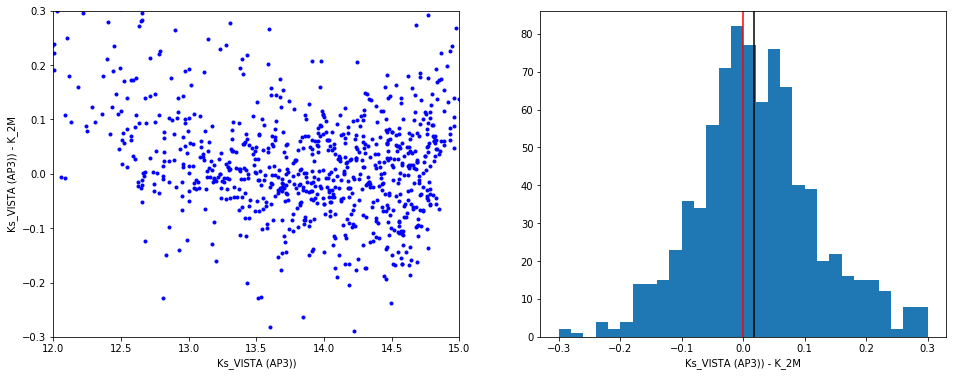

In [210]:
total_var = ek2_v[i_2v]**2 + emv[i_v2]**2 +0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
unsaturated = np.where((mv[i_v2]>13) & (mv[i_v2]<14.2))[0]

weighted_bias = np.sum(
    (mv[i_v2][unsaturated]-mk2_v[i_2v][unsaturated])/total_var[unsaturated]
)/np.sum(
    1./total_var[unsaturated])

pl.figure(figsize=(16,6))
pl.subplot(121)
pl.plot(mv[i_v2], mv[i_v2]-mk2_v[i_2v], 'b.')
pl.xlabel('Ks_VISTA (AP3))')
pl.ylabel('Ks_VISTA (AP3)) - K_2M')
pl.ylim(-0.3,0.3)
pl.xlim(12,15)
pl.subplot(122)
pl.hist(mv[i_v2]-mk2_v[i_2v], bins=30, range = [-0.3,0.3])
pl.axvline(np.median(mv[i_v2][unsaturated]-mk2_v[i_2v][unsaturated]), color='r')
pl.axvline(weighted_bias, color='k')
pl.xlabel('Ks_VISTA (AP3)) - K_2M')

In [162]:
print('Median offset: {0:.3f}'.format(np.median(mv[i_v2][unsaturated]-mk2_v[i_2v][unsaturated])))
print('Weighted offset: {0:.3f}'.format(weighted_bias))

Median offset: 0.000
Weighted offset: 0.017


## Read VIDEO stack & crossmatch with CASU

In [185]:
rai, dei, mki, eki, cli = read_video('VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits')

critical_crossmatch = 3.0*(np.sqrt(0.15**2 + 0.15**2))

dist, i_vi = vista_tree.query(
    np.vstack((rai, dei)).T,
)

dist = np.sqrt(
    ((rai - rav[i_vi])*np.cos(dei*np.pi/180.))**2 +
    (dei - dev[i_vi])**2
)*3600.

good_xm = np.where(
    (dist <= critical_crossmatch) &
    (cv[i_vi] == -1)
)[0]

i_vi = i_vi[good_xm]
i_iv = good_xm

## CASU mags to AB

In [204]:
m_vega = mv + 0.05
mab = m_vega + 1.827

## Now comparing magnitudes

Text(0.5, 0, 'Ks_VISTA_AB (AP3)) - Ks_VIDEO (AP3))')

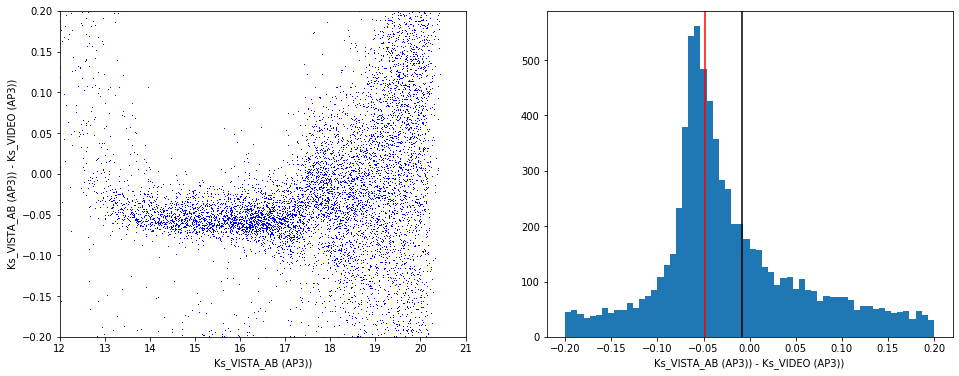

In [211]:
total_var = eki[i_iv]**2 + emv[i_vi]**2 +0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
unsaturated = np.where((mab[i_vi]>14) & (mab[i_vi]<17))[0]

weighted_bias = np.sum(
    (mab[i_vi][unsaturated]-mki[i_iv][unsaturated])/total_var[unsaturated]
)/np.sum(
    1./total_var[unsaturated])

pl.figure(figsize=(16,6))
pl.subplot(121)
pl.plot(mv[i_vi], mab[i_vi]-mki[i_iv], 'b,')
pl.xlabel('Ks_VISTA_AB (AP3))')
pl.ylabel('Ks_VISTA_AB (AP3)) - Ks_VIDEO (AP3))')
pl.ylim(-0.2,0.2)
pl.xlim(12,21)
pl.subplot(122)
pl.hist(mab[i_vi]-mki[i_iv], bins=60, range = [-0.2,0.2])
pl.axvline(np.median(mab[i_vi][unsaturated]-mki[i_iv][unsaturated]), color='r')
pl.axvline(weighted_bias, color='k')
pl.xlabel('Ks_VISTA_AB (AP3)) - Ks_VIDEO (AP3))')

In [206]:
print('Median offset: {0:.3f}'.format(np.median(mab[i_vi][unsaturated]-mki[i_iv][unsaturated])))
print('Weighted offset: {0:.3f}'.format(weighted_bias))

Median offset: -0.048
Weighted offset: -0.008


## Now VIDEO and 2MASS

In [216]:
video_tree = tree(
    np.vstack((rai, dei)).T,
)

critical_crossmatch = 3.0*(np.sqrt(0.15**2 + 0.1**2))

dist, i_i2 = video_tree.query(
    np.vstack((ra2, de2)).T,
)

dist = np.sqrt(
    ((ra2 - rai[i_i2])*np.cos(de2*np.pi/180.))**2 +
    (de2 - dei[i_i2])**2
)*3600.

good_xm = np.where(
    (dist <= critical_crossmatch) &
    (c2jk == 'AA')
)[0]

i_i2 = i_i2[good_xm]
i_2i = good_xm

## VIDEO to VEGA

In [217]:
m_vega = mki - 1.827

Text(0.5, 0, 'Ks_VISTA (AP3)) - K_2M')

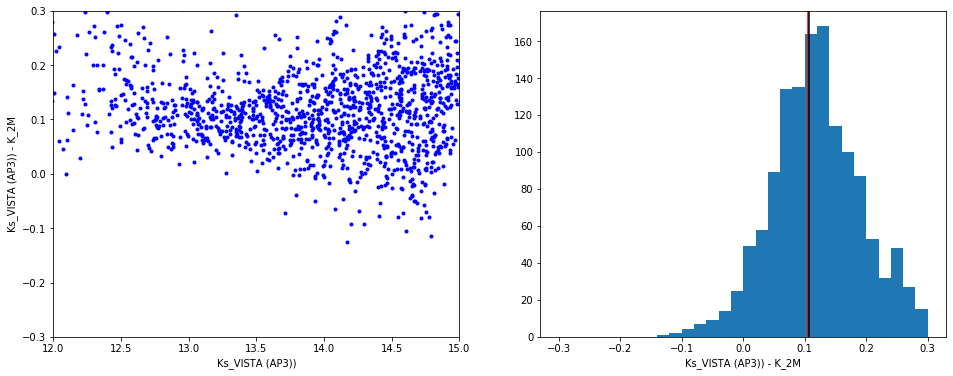

In [219]:
total_var = ek2_v[i_2i]**2 + eki[i_i2]**2 +0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
unsaturated = np.where((m_vega[i_i2]>13) & (m_vega[i_i2]<14.2))[0]

weighted_bias = np.sum(
    (m_vega[i_i2][unsaturated]-mk2_v[i_2i][unsaturated])/total_var[unsaturated]
)/np.sum(
    1./total_var[unsaturated])

pl.figure(figsize=(16,6))
pl.subplot(121)
pl.plot(m_vega[i_i2], m_vega[i_i2]-mk2_v[i_2i], 'b.')
pl.xlabel('Ks_VISTA (AP3))')
pl.ylabel('Ks_VISTA (AP3)) - K_2M')
pl.ylim(-0.3,0.3)
pl.xlim(12,15)
pl.subplot(122)
pl.hist(m_vega[i_i2]-mk2_v[i_2i], bins=30, range = [-0.3,0.3])
pl.axvline(np.median(m_vega[i_i2][unsaturated]-mk2_v[i_2i][unsaturated]), color='r')
pl.axvline(weighted_bias, color='k')
pl.xlabel('Ks_VISTA (AP3)) - K_2M')

In [220]:
print('Median offset: {0:.3f}'.format(np.median(m_vega[i_i2][unsaturated]-mk2_v[i_2i][unsaturated])))
print('Weighted offset: {0:.3f}'.format(weighted_bias))

Median offset: 0.105
Weighted offset: 0.107
